In [78]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-02-27 03:18:56.317754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 03:18:56.317820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 03:18:56.341016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 03:18:57.661485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import library

In [79]:
from time import time
from timeit import default_timer as timer
from datetime import timedelta, datetime
import re
import os
import io
import pickle
import sys
import subprocess
from glob import glob
import csv
import math
import codecs
import copy
from tqdm import tqdm

# EDA
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import pandas as pd

# NLP & ML 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score
)

# DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    InputSpec,
    Layer, 
    Input,
    Embedding, 
    Conv1D, 
    Conv2D, 
    Bidirectional, 
    Dense, 
    Attention,
    LSTM, 
    Activation, 
    Add, 
    Flatten, 
    Concatenate, 
    concatenate,
    Reshape, 
    Dropout, 
    SpatialDropout1D, 
    BatchNormalization,
    MaxPooling1D, 
    MaxPool2D, 
    GlobalAveragePooling1D, 
    GlobalMaxPooling1D, 
    GlobalMaxPool1D
)
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Plotting code

In [80]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
#     from itertools import izip
    pc.update_scalarmappable()
    ax = pc.axes# FOR LATEST MATPLOTLIB
    
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        # ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      
    
    # save the figure
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    

#
def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    
# Function to plot the training and validation loss and accuracy
def plot_loss_accuracy(history, model_name):
    # plot the training and validation loss
    plt.plot(history.epoch, history.history['loss'], '-o', label='Training_loss')
    plt.plot(history.epoch, history.history['val_loss'], '-o', label='Validation_loss')
    plt.title(model_name + ' model loss')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    
    # plot the training and validation accuracy
    plt.plot(history.epoch, history.history['accuracy'], '-o', label='Training_accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='Validation_accuracy')
    plt.title(model_name + ' model accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def plot_class_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

# Data Preprocessing

## Vectorization of the datasets
Encoding the text data into numerical data for the deep learning models

In [81]:
#load the datasets
print('Loading datasets...')
train_set= pd.read_csv('datasets/train_set_ready.csv')
val_set = pd.read_csv('datasets/val_set_ready.csv')
test_set = pd.read_csv('datasets/test_set_ready.csv')

# import all augmented dataset
train_set_EnKo = pd.read_csv('datasets/train_set_EnKo_ready.csv')
train_set_ChKo = pd.read_csv('datasets/train_set_ChKo_ready.csv')
train_set_JaKo = pd.read_csv('datasets/train_set_JaKo_ready.csv')
train_set_all = pd.read_csv('datasets/train_set_all_ready.csv')

print('Datasets loaded.')

Loading datasets...
Datasets loaded.


In [82]:
# define the train and test sets data from the dataframes
X_train = train_set['corpus']
X_train_1 = train_set['corpus_1']
y_train = train_set['label']

X_val = val_set['corpus']
X_val_1 = val_set['corpus_1']
y_val = val_set['label']

X_test = test_set['corpus']
X_test_1 = test_set['corpus_1']
y_test = test_set['label']

X_train_EnKo = train_set_EnKo['corpus']
X_train_EnKo_1 = train_set_EnKo['corpus_1']
y_train_EnKo = train_set_EnKo['label']

X_train_ChKo = train_set_ChKo['corpus']
X_train_ChKo_1 = train_set_ChKo['corpus_1']
y_train_ChKo = train_set_ChKo['label']

X_train_JaKo = train_set_JaKo['corpus']
X_train_JaKo_1 = train_set_JaKo['corpus_1']
y_train_JaKo = train_set_JaKo['label']

X_train_all = train_set_all['corpus']
X_train_all_1 = train_set_all['corpus_1']
y_train_all = train_set_all['label']

In [83]:
# write a function to pick the right augmented dataset to be used for the training
def pick_augmented_dataset(augmented_dataset, X_train, X_train_1, y_train):
    """
    Function to pick the right augmented dataset to be used for the training
    
    Parameters:
    augmented_dataset: str, default='default'
        The augmented dataset to be used for the training. It can be 'EnKo', 'ChKo', 'JaKo', 'All' or 'default' (original dataset)
    X_train: list or array
        The original trainset
    X_train_1: list or array
        The original trainset
    y_train: list or array
        The original trainset
    """
    if augmented_dataset == 'EnKo':
        X_train = X_train_EnKo
        X_train_1 = X_train_EnKo_1
        y_train = y_train_EnKo
        print('Using the EnKo augmented dataset for the training')
    elif augmented_dataset == 'ChKo':
        X_train = X_train_ChKo
        X_train_1 = X_train_ChKo_1
        y_train = y_train_ChKo
        print('Using the ChKo augmented dataset for the training')
    elif augmented_dataset == 'JaKo':
        X_train = X_train_JaKo
        X_train_1 = X_train_JaKo_1
        y_train = y_train_JaKo
        print('Using the JaKo augmented dataset for the training')
    elif augmented_dataset == 'All':
        X_train = X_train_all
        X_train_1 = X_train_all_1
        y_train = y_train_all
        print('Using the All augmented dataset for the training')
    else:
        X_train = X_train
        X_train_1 = X_train_1
        y_train = y_train
        print('Using the original dataset for the training')
    return X_train, X_train_1, y_train

In [84]:
# pick the right augmented dataset to be used for the training
augmented_dataset = 'All' # 'EnKo', 'ChKo', 'JaKo', 'All' or 'original
X_train, X_train_1, y_train = pick_augmented_dataset(augmented_dataset, X_train, X_train_1, y_train)

Using the All augmented dataset for the training


In [85]:
# Function to define the maximum number of words to be used
def max_words_func(X_train, X_val, X_test):
    max_len = 0
    max_words = 0
 
    # check the length of the trainset, the valset and the testset
    print('Train set size = {} \nValidation set size = {} \nTest set size = {}'.format(len(X_train), len(X_val), len(X_test)))
    
    # count the maximum number of words in the trainset
    max_words = len(set(" ".join(X_train).split())) # max number of words for tokenizer
    print('Maximum number of words in the train set = {}'.format(max_words))
    
    # get the maximum length of the sentences in the trainset
    max_len = max([len(x.split()) for x in X_train]) # max length of each sentences, including padding
    print('Maximum length of a sentence in the train set = {}'.format(max_len))

    return max_words, max_len

In [86]:
# define the maximum number of words and the maximum length of the sentences in the trainset
max_words, max_len = max_words_func(X_train, X_val, X_test)

Train set size = 3501 
Validation set size = 440 
Test set size = 440
Maximum number of words in the train set = 34968
Maximum length of a sentence in the train set = 4715


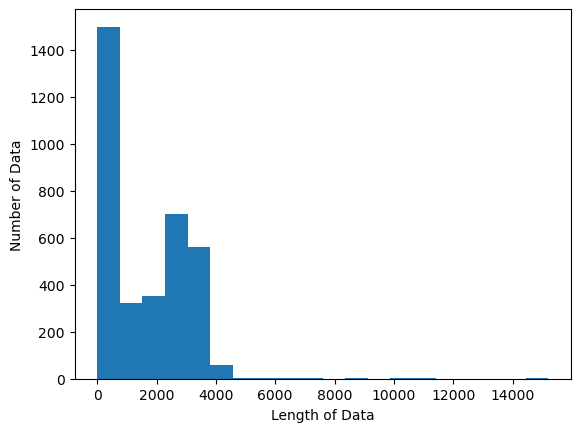

In [87]:
plt.hist([len(s) for s in X_train], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

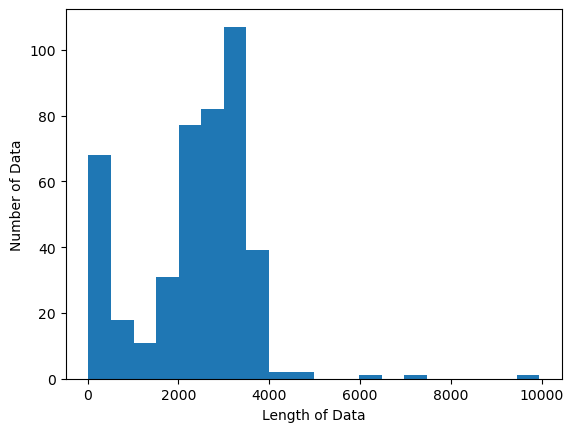

In [88]:
plt.hist([len(s) for s in X_test], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

### Traininig with the original train_set dataset

In [89]:
# Function to tokenize the text data
def tokenize_text(X_train, X_val, X_test, max_words=max_words, max_len=max_len):
    # define the tokenizer and tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=False, char_level=False)
    tokenizer.fit_on_texts(X_train)  #leaky
    
    # Function to convert texts to sequences of integers
    def texts_to_sequences(X_train, X_val, X_test):
        # convert texts to sequences of integers
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_val_seq = tokenizer.texts_to_sequences(X_val)
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        word_index = tokenizer.word_index
        
        print("Dictionary size: ", len(word_index))
        
        return X_train_seq, X_val_seq, X_test_seq, word_index
    
    # define the sequences of integers
    X_train_seq, X_val_seq, X_test_seq, word_index = texts_to_sequences(X_train, X_val, X_test)
    
    # FPad the sequences to ensure uniform length
    X_train_pad = pad_sequences(X_train_seq, padding='pre', maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, padding='pre', maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, padding='pre', maxlen=max_len)
    
    return X_train_pad, X_val_pad, X_test_pad, word_index

In [90]:
# tokenize the text data
X_train_pad, X_val_pad, X_test_pad, word_index = tokenize_text(X_train, X_val, X_test, max_words, max_len)

Dictionary size:  34968


# Model Building and Training

## Importing the FastText word embeddings

In [91]:
# run if the wiki.ko.vec is not available in the same directory
import os
import urllib.request
# check if the file wiki.ko.vec is in the directory if not download it
if not os.path.isfile('wiki.ko.vec'):
    print('wiki.ko.vec does not exist, downloading file from the internet')
    # download the FastText word embeddings and monitor the download progress bar with tqdm
    with tqdm(unit='B', unit_scale=True, miniters=1, desc='wiki.ko.vec') as t:
        urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec', reporthook=lambda a,b,c: t.update(c))
    # urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec')
else:
    print('wiki.ko.vec exists, will not download file from the internet')

wiki.ko.vec exists, will not download file from the internet


In [15]:
# import the FastText word embeddings
print('Loading word FastText embeddings...')
embeddings_index = {}
f = codecs.open('wiki.ko.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Loading word FastText embeddings...


879131it [11:25, 1282.94it/s]


In [92]:
print('Found %s word vectors' % len(embeddings_index))

Found 879130 word vectors


In [93]:
# define the preprocessing parameters
embedding_dim = 300 # embedding dimensions for word vectors (word2vec/GloVe/Fasttext)

# defining the hyperparameters
learning_rate = 0.05 # 1e-2, 1e-3, 5e-2
batch_size= 32 # 16, 32, 64, 128
epochs = 10
steps_per_epoch = len(X_train) // batch_size  # total_samples is the training set size

# Calculating decay steps
# It's common to decay the learning rate at each epoch
decay_steps = steps_per_epoch * epochs # 10000
decay_rate = 0.9  # This is a common decay rate, but you can adjust it
# learning_decay = 1e-10 # 1e-4

spa_dropout_ratio = 0.2 # 0 to 1 dropout ratio, dropping an entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.2 # 0.1, 0.2 to 0.5 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.

### Preparing FastText embedding matrix for future use

In [94]:
#embedding matrix
# print('Preparing embedding matrix for future use...')
words_not_found = []
embed_dim = embedding_dim #300 # 32 Dimensions of the embedding vector
nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((max_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

number of null word embeddings: 9032
sample words not found:  ['어땠' '빠지' '친숙' '농사지' '대출자' '개소주' '헛나오' '꼴등' '아찔' '수욕']


In [95]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results

,F1_score,Precision,Recall,Accuracy,Training time


## Training with default embedding layer and the original train_set dataset

### Single LSTM layer

In [96]:
# write a function to build, train and evaluate the LSTM model
def build_train_lstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1))
    model.add(Dense(dense_units, activation='relu'))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/LSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    # print(confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
        
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
        
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [97]:
# build, train and evaluate the LSTM model
model_name = augmented_dataset + '_LSTM'
model_lstm, history_lstm, report_lstm = build_train_lstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_12 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 lstm_12 (LSTM)              (None, 64)                93440     
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 29s 245ms/step - loss: 0.7135 - accuracy: 0.5393 - val_loss: 0.7331 - val_accuracy: 0.2386
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.5538
Epoch 2: val_accuracy did not improve from 0.23864
110/110 [==============================] - 25s 223ms/step - loss: 0.6889 - accuracy: 0.5538 - val_loss: 0.7574 - val_accuracy: 0.2386
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5476
Epoch 3: val_accuracy did not improve from 0.23864
110/110 [==============================] - 26s 238ms/step - loss: 0.6875 - accuracy: 0.5476 - val_loss: 0.8194 - val_accuracy: 0.2386
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5538
Epoch 4: val_accuracy did not improve from 0.23864
110/110 [==============================] - 35s 316ms/step - loss: 0.6890 - accuracy: 0.5538 - val_loss: 0.7306 - val_accuracy: 0.2386
Epoch 5/10
110/110 [===

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [98]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.0,0.238636,221.3377


#### Plot the results

[0.0, 0.0, 0.0]
[0.2386, 1.0, 0.3853]
plotMat: [[0.0, 0.0, 0.0], [0.2386, 1.0, 0.3853]]
support: [335, 105]


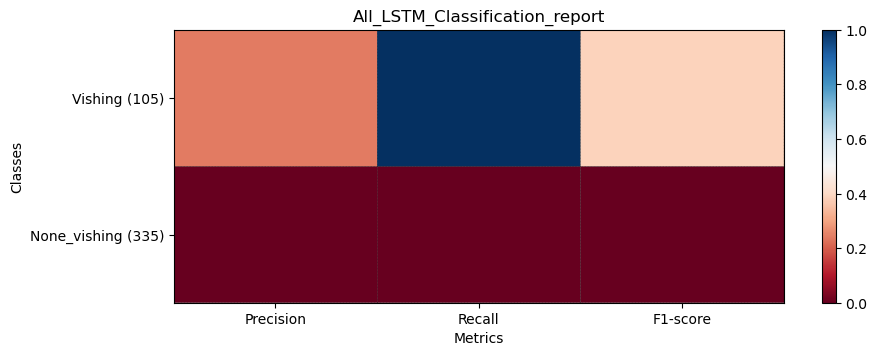

In [99]:
plot_name = augmented_dataset + '_LSTM_Classification_report'
plot_classification_report(report_lstm, plot_name)

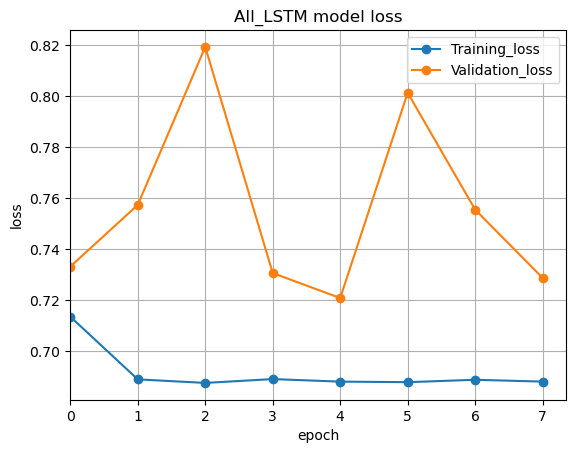

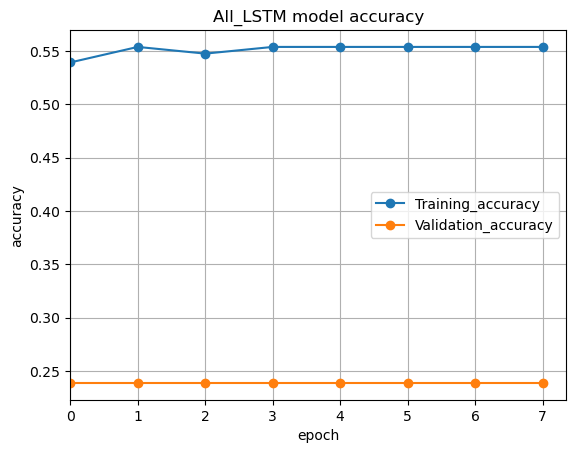

In [100]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_LSTM'
plot_loss_accuracy(history_lstm, plot_name)

In [101]:
# plot the tensorboard results
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# %tensorboard --logdir logs/fit

### Single LSTM layer with FastText embedding layer

In [102]:
# build, train and evaluate the LSTM model
model_name = augmented_dataset + '_LSTM_FT'
model_lstm_ft, history_lstm_ft, report_lstm_ft = build_train_lstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_13 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 lstm_13 (LSTM)              (None, 64)                93440     
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 28s 239ms/step - loss: nan - accuracy: 0.5310 - val_loss: nan - val_accuracy: 0.7614
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4462
Epoch 2: val_accuracy did not improve from 0.76136
110/110 [==============================] - 25s 231ms/step - loss: nan - accuracy: 0.4462 - val_loss: nan - val_accuracy: 0.7614
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4462
Epoch 3: val_accuracy did not improve from 0.76136
110/110 [==============================] - 26s 238ms/step - loss: nan - accuracy: 0.4462 - val_loss: nan - val_accuracy: 0.7614
Epoch 3: early stopping
Training time: 79.7671332359314
14/14 [==============================] - 2s 115ms/step - loss: nan - accuracy: 0.7614
Test Loss: nan
Test Accuracy: 0.7613636255264282
14/14 [==============================] - 2s 102ms/step
Precision: 0.0
Recall: 0.0
F1-score: 0.0
              precision    recall  f1-sco

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [103]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.0,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.0,0.761364,79.767133


[0.7614, 1.0, 0.8645]
[0.0, 0.0, 0.0]
plotMat: [[0.7614, 1.0, 0.8645], [0.0, 0.0, 0.0]]
support: [335, 105]


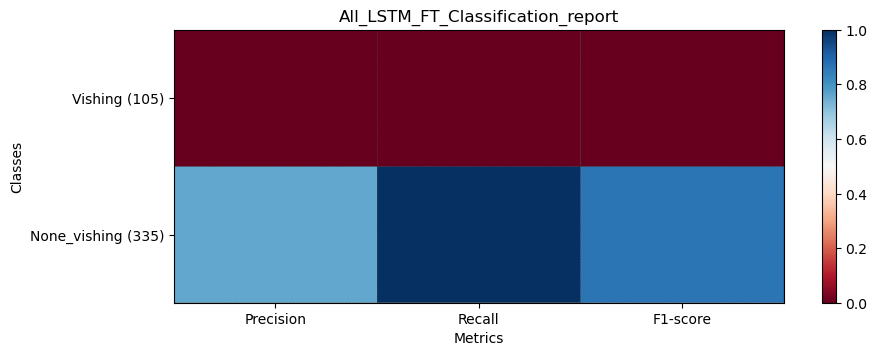

In [104]:
plot_name = augmented_dataset + '_LSTM_FT_Classification_report'
plot_classification_report(report_lstm_ft, plot_name)

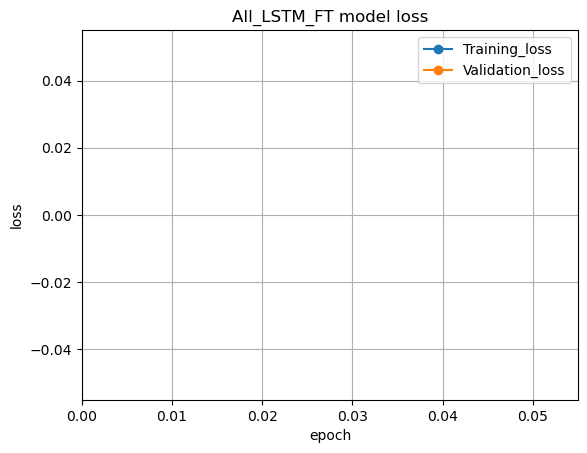

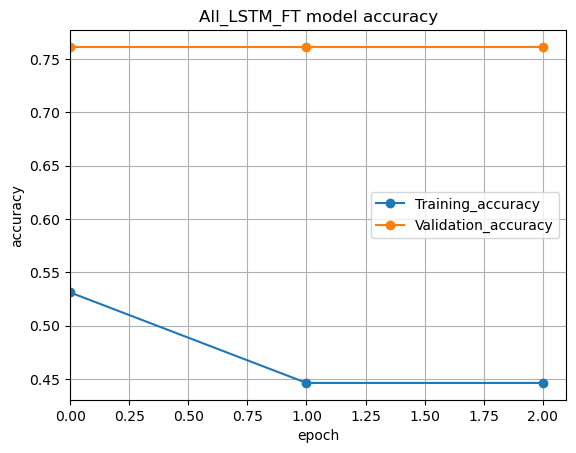

In [105]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_LSTM_FT'
plot_loss_accuracy(history_lstm_ft, plot_name)

### Stacked LSTM layers


In [106]:
# write a function to build, train and evaluate the LSTM model
def build_train_stackedlstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1, return_sequences=True))
    model.add(LSTM(lstm_units_2))
    model.add(Dense(dense_units, activation='relu'))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    # print(confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
        
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
        
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [107]:
# build, train and evaluate the stacked LSTM layers model
model_name = augmented_dataset + '_stackedLSTM'
model_stackedlstm, history_stackedlstm, report_stackedlstm = build_train_stackedlstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_14 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 lstm_14 (LSTM)              (None, 4715, 64)          93440     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_28 (Dense)            (None, 64)                2112      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 55s 477ms/step - loss: 0.6975 - accuracy: 0.5444 - val_loss: 0.7700 - val_accuracy: 0.2386
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5538
Epoch 2: val_accuracy did not improve from 0.23864
110/110 [==============================] - 50s 453ms/step - loss: 0.6884 - accuracy: 0.5538 - val_loss: 0.7482 - val_accuracy: 0.2386
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5538
Epoch 3: val_accuracy did not improve from 0.23864
110/110 [==============================] - 51s 461ms/step - loss: 0.6894 - accuracy: 0.5538 - val_loss: 0.7595 - val_accuracy: 0.2386
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.5538
Epoch 4: val_accuracy did not improve from 0.23864
110/110 [==============================] - 49s 444ms/step - loss: 0.6880 - accuracy: 0.5538 - val_loss: 0.7033 - val_accuracy: 0.2386
Epoch 5/10
110/110 [===

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [108]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.0,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.0,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.0,0.238636,351.369261


[0.0, 0.0, 0.0]
[0.2386, 1.0, 0.3853]
plotMat: [[0.0, 0.0, 0.0], [0.2386, 1.0, 0.3853]]
support: [335, 105]


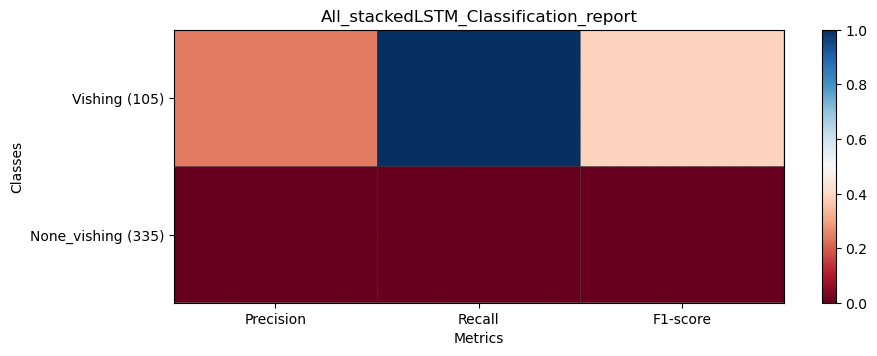

In [109]:
plot_name = augmented_dataset + '_stackedLSTM_Classification_report'
plot_classification_report(report_stackedlstm, plot_name)

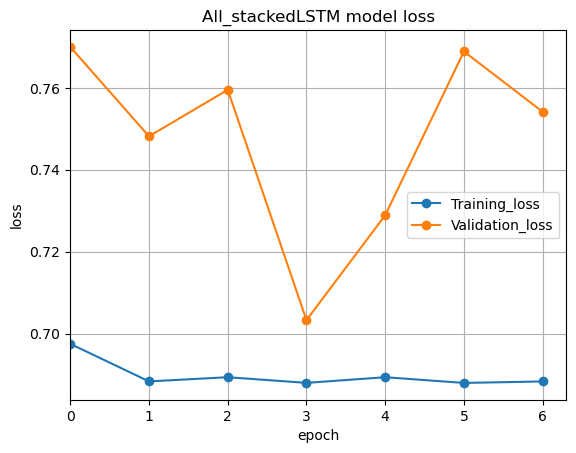

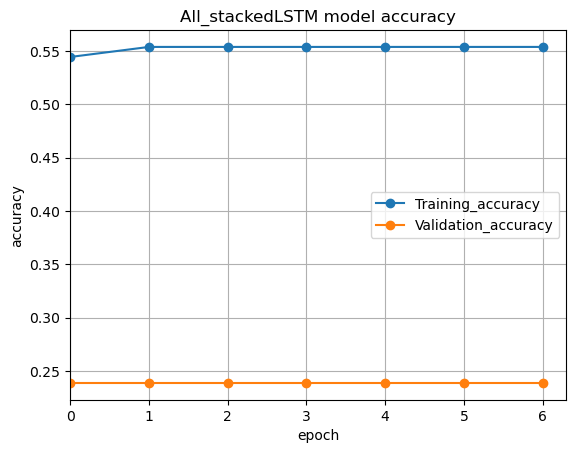

In [110]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_stackedLSTM'
plot_loss_accuracy(history_stackedlstm, plot_name)

### Stacked LSTM layer with FastText embedding layer


In [111]:
# build, train and evaluate the stacked LSTM layers model with FastText embedding layer
model_name = augmented_dataset + '_stackedLSTM_FT'
model_stackedlstm_ft, history_stackedlstm_ft, report_stackedlstm_ft = build_train_stackedlstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_15 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 lstm_16 (LSTM)              (None, 4715, 64)          93440     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dense_30 (Dense)            (None, 64)                2112      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 53s 459ms/step - loss: 0.3351 - accuracy: 0.8655 - val_loss: 3.2882 - val_accuracy: 0.2386
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8506
Epoch 2: val_accuracy improved from 0.23864 to 0.99091, saving model to models/All_stackedLSTM_FT_20240227_033059.h5
110/110 [==============================] - 49s 445ms/step - loss: 0.3294 - accuracy: 0.8506 - val_loss: 0.0228 - val_accuracy: 0.9909
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.0964 - accuracy: 0.9749
Epoch 3: val_accuracy did not improve from 0.99091
110/110 [==============================] - 50s 457ms/step - loss: 0.0964 - accuracy: 0.9749 - val_loss: 0.6683 - val_accuracy: 0.8227
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9723
Epoch 4: val_accuracy did not improve from 0.99091
110/110 [==============================] - 49s 443ms/step - loss: 0.0921 - accuracy: 0.9723

In [112]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.0,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.0,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.0,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.0,0.997727,502.263439


[1.0, 0.997, 0.9985]
[0.9906, 1.0, 0.9953]
plotMat: [[1.0, 0.997, 0.9985], [0.9906, 1.0, 0.9953]]
support: [335, 105]


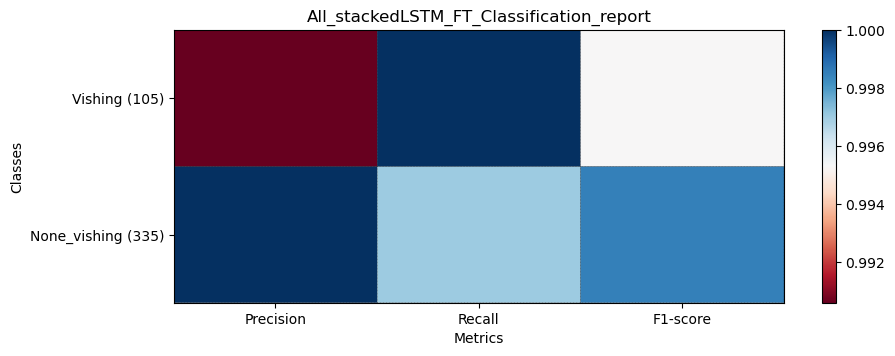

In [113]:
#plot the confusion matrix
plot_name = augmented_dataset + '_stackedLSTM_FT_Classification_report'
plot_classification_report(report_stackedlstm_ft, plot_name)

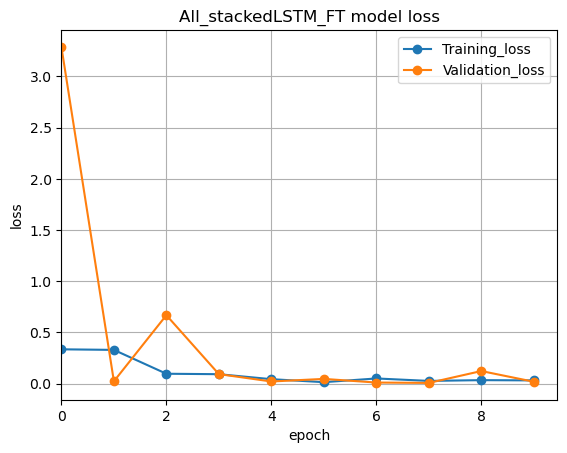

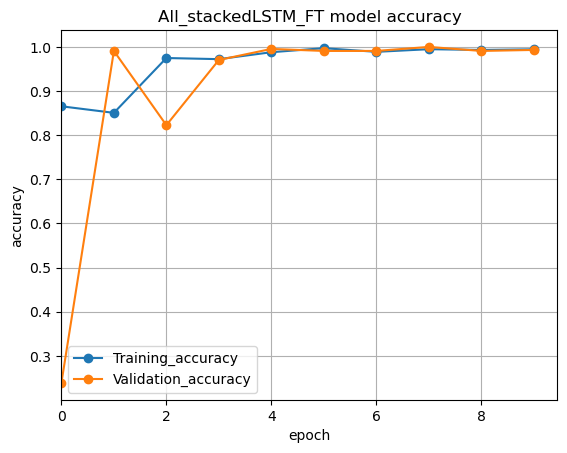

In [114]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_stackedLSTM_FT'
plot_loss_accuracy(history_stackedlstm_ft, plot_name)

### Single BiLSTM layer

In [115]:
# Function to build, train and evaluate the BiLSTM model
def build_train_bilstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Bidirectional(LSTM(lstm_units_1)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    # print(confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
        
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
        
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [116]:
# build, train and evaluate the BiLSTM model
model_name = augmented_dataset + '_BiLSTM'
model_bilstm, history_bilstm, report_bilstm = build_train_bilstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_16 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_6 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)               

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 57s 499ms/step - loss: nan - accuracy: 0.4670 - val_loss: nan - val_accuracy: 0.7614
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4462
Epoch 2: val_accuracy did not improve from 0.76136
110/110 [==============================] - 55s 495ms/step - loss: nan - accuracy: 0.4462 - val_loss: nan - val_accuracy: 0.7614
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4462
Epoch 3: val_accuracy did not improve from 0.76136
110/110 [==============================] - 56s 507ms/step - loss: nan - accuracy: 0.4462 - val_loss: nan - val_accuracy: 0.7614
Epoch 3: early stopping
Training time: 167.9560022354126
14/14 [==============================] - 3s 217ms/step - loss: nan - accuracy: 0.7614
Test Loss: nan
Test Accuracy: 0.7613636255264282
14/14 [==============================] - 26s 216ms/step
Precision: 0.0
Recall: 0.0
F1-score: 0.0
              precision    recall  f1-s

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [117]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.0,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.0,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.0,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.0,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.0,0.761364,167.956002


[0.7614, 1.0, 0.8645]
[0.0, 0.0, 0.0]
plotMat: [[0.7614, 1.0, 0.8645], [0.0, 0.0, 0.0]]
support: [335, 105]


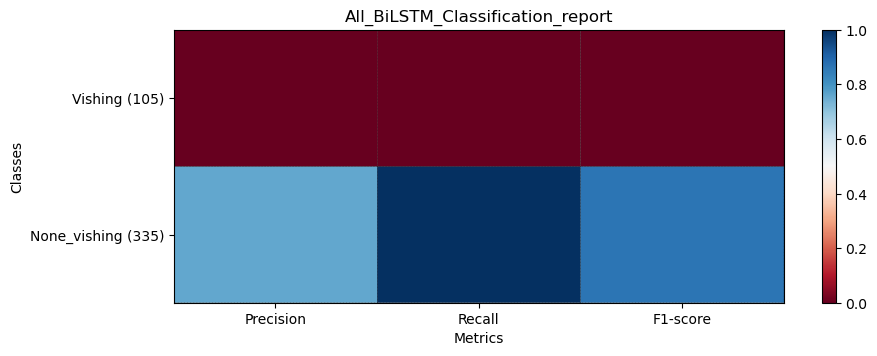

In [118]:
#plot the confusion matrix
plot_name = augmented_dataset + '_BiLSTM_Classification_report'
plot_classification_report(report_bilstm, plot_name)

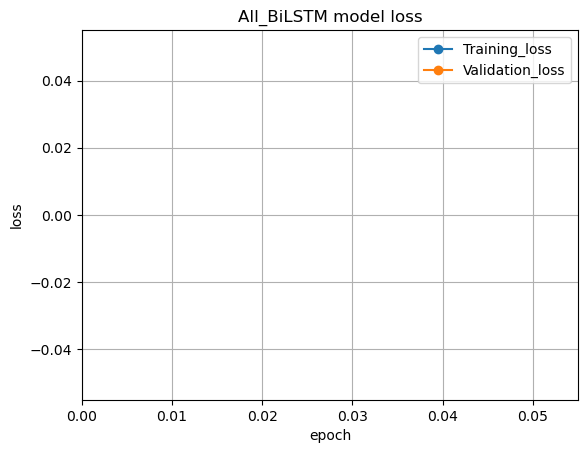

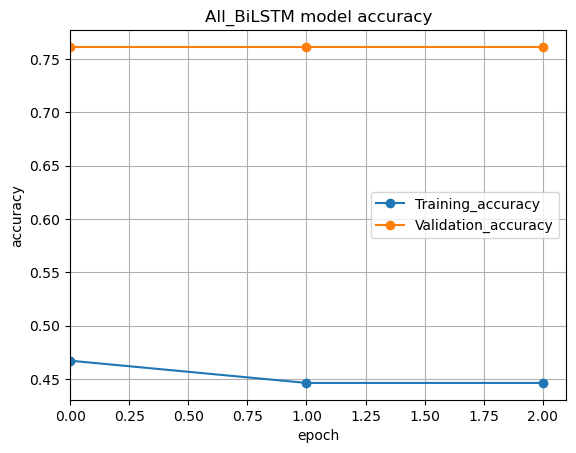

In [119]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_BiLSTM'
plot_loss_accuracy(history_bilstm, plot_name)

### Single BiLSTM layer with FastText embedding layer

In [120]:
# build, train and evaluate the BiLSTM model with FastText embedding layer
model_name = augmented_dataset + '_BiLSTM_FT'
model_bilstm_ft, history_bilstm_ft, report_bilstm_ft = build_train_bilstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_17 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               186880    
 onal)                                                           
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 1)               

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 59s 502ms/step - loss: 0.5177 - accuracy: 0.7315 - val_loss: 0.1676 - val_accuracy: 0.9477
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.8986
Epoch 2: val_accuracy did not improve from 0.94773
110/110 [==============================] - 51s 464ms/step - loss: 0.2452 - accuracy: 0.8986 - val_loss: 0.1999 - val_accuracy: 0.9409
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9586
Epoch 3: val_accuracy improved from 0.94773 to 0.99545, saving model to models/All_BiLSTM_FT_20240227_034250.h5
110/110 [==============================] - 54s 489ms/step - loss: 0.1213 - accuracy: 0.9586 - val_loss: 0.0605 - val_accuracy: 0.9955
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9283
Epoch 4: val_accuracy did not improve from 0.99545
110/110 [==============================] - 51s 460ms/step - loss: 0.2311 - accuracy: 0.9283 - va

In [121]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.000000,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.000000,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.000000,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.000000,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.000000,0.761364,167.956002
All_BiLSTM_FT,0.966825,0.962264,0.971429,0.984091,511.583563


[0.991, 0.9881, 0.9895]
[0.9623, 0.9714, 0.9668]
plotMat: [[0.991, 0.9881, 0.9895], [0.9623, 0.9714, 0.9668]]
support: [335, 105]


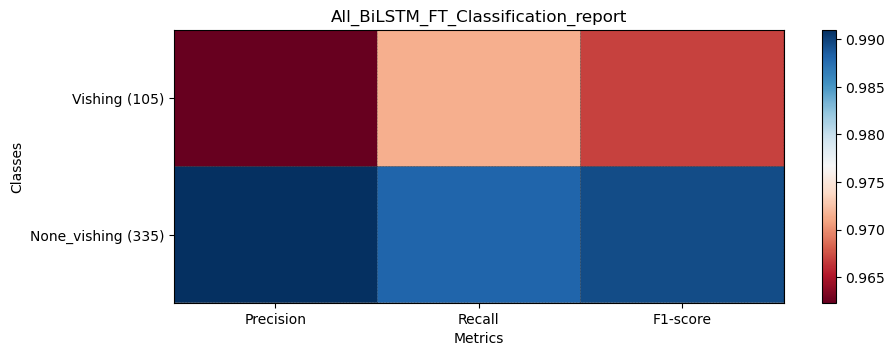

In [122]:
#plot the confusion matrix
plot_name = augmented_dataset + '_BiLSTM_FT_Classification_report'
plot_classification_report(report_bilstm_ft, plot_name)

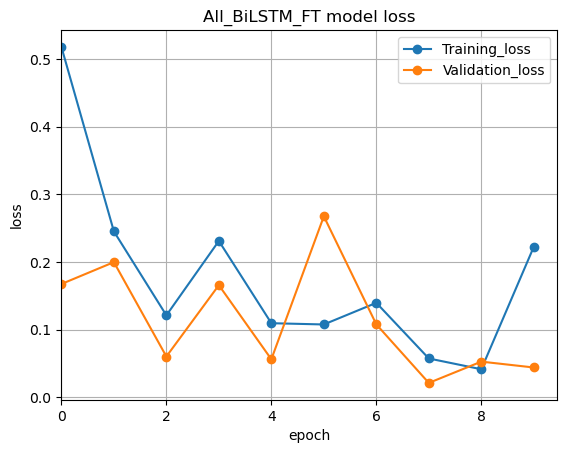

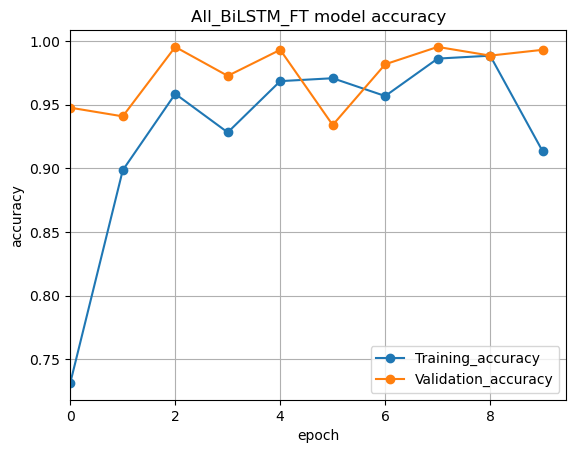

In [123]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_BiLSTM_FT'
plot_loss_accuracy(history_bilstm_ft, plot_name)

### Stacked BiLSTM layers

In [124]:
# Function to build, train and evaluate the stacked BiLSTM model
def build_train_stackedbilstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_units_2)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    # print(confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
        
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
        
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [125]:
# build, train and evaluate the stacked BiLSTM model
model_name = augmented_dataset + '_stackedBiLSTM'
model_stackedbilstm, history_stackedbilstm, report_stackedbilstm = build_train_stackedbilstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_18 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_8 (Bidirecti  (None, 4715, 128)         186880    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 104s 894ms/step - loss: 0.6984 - accuracy: 0.5510 - val_loss: 0.7202 - val_accuracy: 0.2386
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.6041
Epoch 2: val_accuracy did not improve from 0.23864
110/110 [==============================] - 96s 875ms/step - loss: 0.6591 - accuracy: 0.6041 - val_loss: 0.7843 - val_accuracy: 0.2386
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5507
Epoch 3: val_accuracy did not improve from 0.23864
110/110 [==============================] - 96s 875ms/step - loss: 0.6881 - accuracy: 0.5507 - val_loss: 0.7654 - val_accuracy: 0.2386
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5538
Epoch 4: val_accuracy did not improve from 0.23864
110/110 [==============================] - 100s 908ms/step - loss: 0.6879 - accuracy: 0.5538 - val_loss: 0.7679 - val_accuracy: 0.2386
Epoch 4: early stoppi

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [126]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.000000,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.000000,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.000000,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.000000,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.000000,0.761364,167.956002
All_BiLSTM_FT,0.966825,0.962264,0.971429,0.984091,511.583563
All_stackedBiLSTM,0.385321,0.238636,1.000000,0.238636,396.791831


[0.0, 0.0, 0.0]
[0.2386, 1.0, 0.3853]
plotMat: [[0.0, 0.0, 0.0], [0.2386, 1.0, 0.3853]]
support: [335, 105]


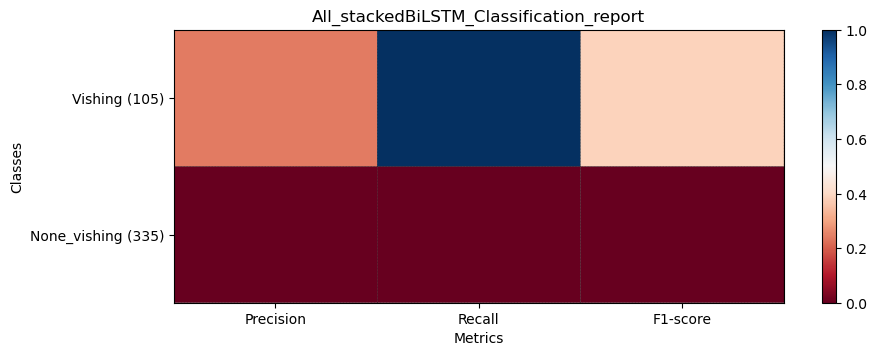

In [127]:
#plot the confusion matrix
plot_name = augmented_dataset + '_stackedBiLSTM_Classification_report'
plot_classification_report(report_stackedbilstm, plot_name)

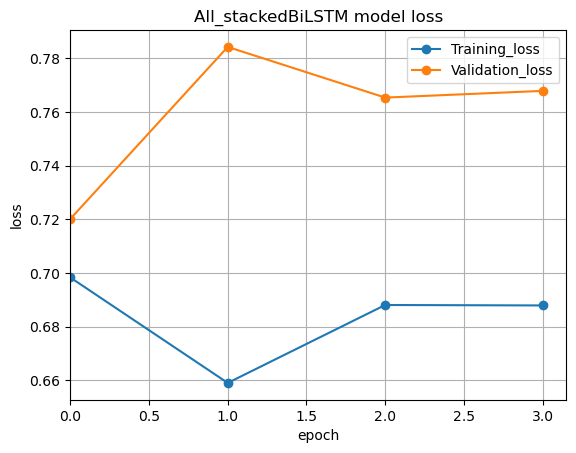

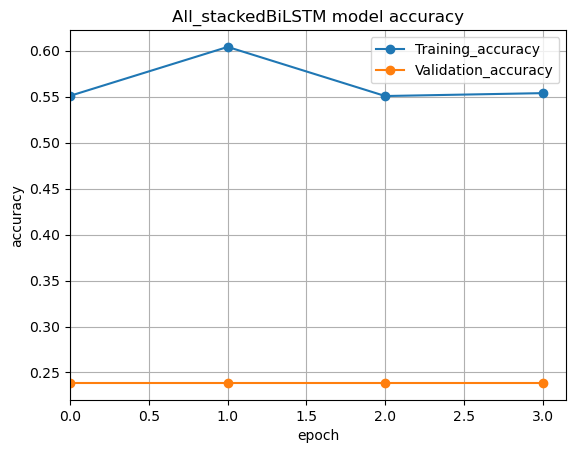

In [128]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_stackedBiLSTM'
plot_loss_accuracy(history_stackedbilstm, plot_name)

### Stacked BiLSTM layer with FastText embedding layer with FastText embedding layer

In [129]:
# build, train and evaluate the stacked BiLSTM model with FastText embedding layer
model_name = augmented_dataset + '_stackedBiLSTM_FT'
model_stackedbilstm_ft, history_stackedbilstm_ft, report_stackedbilstm_ft = build_train_stackedbilstm_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_19 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_10 (Bidirect  (None, 4715, 128)         186880    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 110s 890ms/step - loss: 0.3992 - accuracy: 0.8403 - val_loss: 0.2386 - val_accuracy: 0.9523
Epoch 2/10
110/110 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9314
Epoch 2: val_accuracy improved from 0.95227 to 0.95682, saving model to models/All_stackedBiLSTM_FT_20240227_035823.h5
110/110 [==============================] - 97s 881ms/step - loss: 0.2216 - accuracy: 0.9314 - val_loss: 0.1137 - val_accuracy: 0.9568
Epoch 3/10
110/110 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9700
Epoch 3: val_accuracy improved from 0.95682 to 0.96818, saving model to models/All_stackedBiLSTM_FT_20240227_035823.h5
110/110 [==============================] - 98s 892ms/step - loss: 0.1200 - accuracy: 0.9700 - val_loss: 0.1005 - val_accuracy: 0.9682
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.9760
Epoch 4: val_accuracy improved from 0.96818 to 0.97727, saving model to

In [130]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.000000,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.000000,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.000000,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.000000,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.000000,0.761364,167.956002
All_BiLSTM_FT,0.966825,0.962264,0.971429,0.984091,511.583563
All_stackedBiLSTM,0.385321,0.238636,1.000000,0.238636,396.791831
All_stackedBiLSTM_FT,0.949772,0.912281,0.990476,0.975000,804.711993


[0.9969, 0.9701, 0.9834]
[0.9123, 0.9905, 0.9498]
plotMat: [[0.9969, 0.9701, 0.9834], [0.9123, 0.9905, 0.9498]]
support: [335, 105]


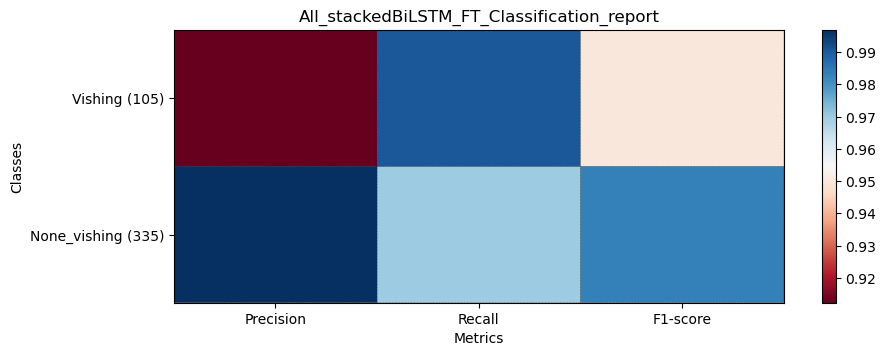

In [131]:
#plot the confusion matrix
plot_name = augmented_dataset + '_stackedBiLSTM_FT_Classification_report'
plot_classification_report(report_stackedbilstm_ft, plot_name)

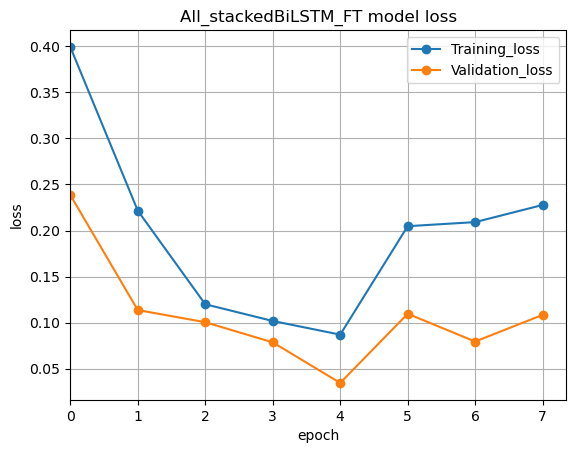

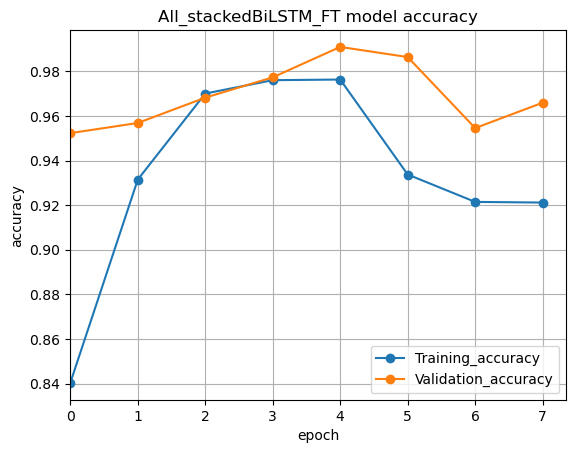

In [132]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_stackedBiLSTM_FT'
plot_loss_accuracy(history_stackedbilstm_ft, plot_name)

### 1D CNN Layer

In [133]:
# Function to build, train and evaluate the stacked BiLSTM model
def build_train_cnn_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))

    model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='valid'))
    model.add(MaxPooling1D())
    # model.add(GlobalMaxPooling1D()) #takes the maximum value over the time dimension from each feature map generated by the convolutional layers, Dimensionality Reduction, Reduces Overfitting
    model.add(Dense(dense_units, activation='relu'))
    model.add(Flatten()) # no need if used Global poooling
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_lossmode='mn'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    # print(confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
        
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
        
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [134]:
# build, train and evaluate the CNN model
model_name = augmented_dataset + '_CNN'
model_cnn, history_cnn, report_cnn = build_train_cnn_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_20 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 conv1d_8 (Conv1D)           (None, 4713, 50)          45050     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 2356, 50)          0         
 g1D)                                                            
                                                                 
 dense_40 (Dense)            (None, 2356, 64)          3264      
                                                                 
 flatten_4 (Flatten)         (None, 150784)          

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 5s 38ms/step - loss: 13.2646 - accuracy: 0.9369 - val_loss: 1.9904e-04 - val_accuracy: 1.0000
Epoch 2/10
109/110 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9946
Epoch 2: val_accuracy did not improve from 1.00000
110/110 [==============================] - 2s 23ms/step - loss: 0.1926 - accuracy: 0.9946 - val_loss: 2.2437e-05 - val_accuracy: 1.0000
Epoch 3/10
109/110 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9991
Epoch 3: val_accuracy did not improve from 1.00000
110/110 [==============================] - 3s 23ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 4.4818e-06 - val_accuracy: 1.0000
Epoch 4/10
109/110 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
110/110 [==============================] - 3s 23ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 2.3641e-06 - val_accuracy: 1.0000
Epoch 5/10
109

In [135]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.000000,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.000000,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.000000,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.000000,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.000000,0.761364,167.956002
All_BiLSTM_FT,0.966825,0.962264,0.971429,0.984091,511.583563
All_stackedBiLSTM,0.385321,0.238636,1.000000,0.238636,396.791831
All_stackedBiLSTM_FT,0.949772,0.912281,0.990476,0.975000,804.711993
All_CNN,1.000000,1.000000,1.000000,1.000000,28.366252


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


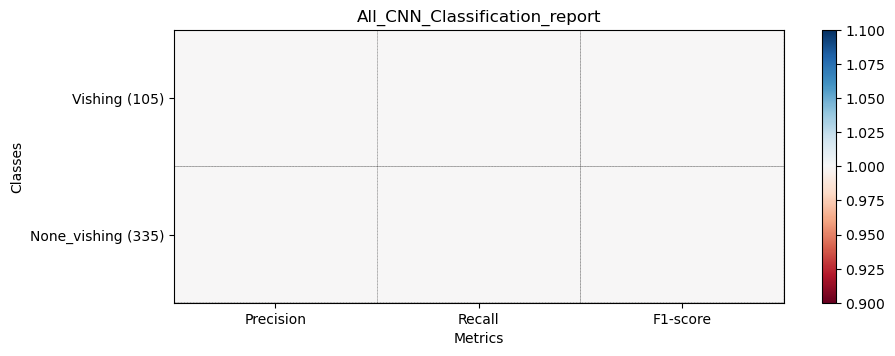

In [136]:
#plot the confusion matrix
plot_name = augmented_dataset + '_CNN_Classification_report'
plot_classification_report(report_cnn, plot_name)

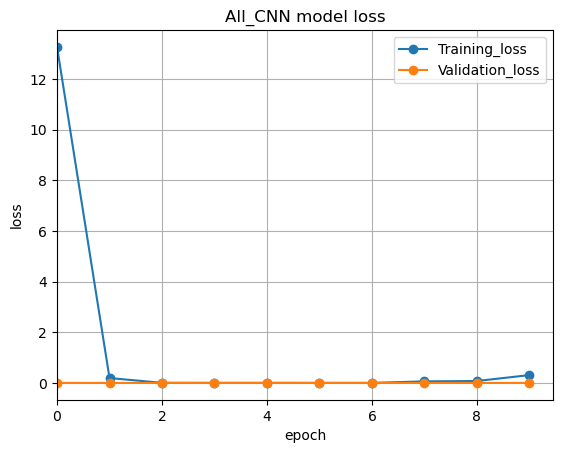

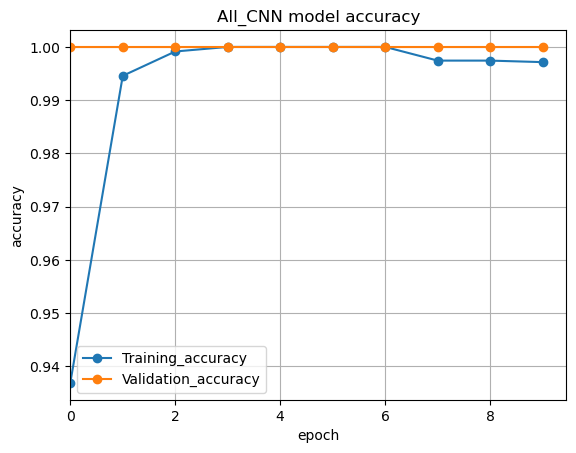

In [137]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_CNN'
plot_loss_accuracy(history_cnn, plot_name)

#### 1D CNN layer with FastText embedding layer

In [138]:
# build, train and evaluate the CNN model with FastText embedding layer
model_name = augmented_dataset + '_CNN_FT'
model_cnn_ft, history_cnn_ft, report_cnn_ft = build_train_cnn_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_21 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 conv1d_9 (Conv1D)           (None, 4713, 50)          45050     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 2356, 50)          0         
 g1D)                                                            
                                                                 
 dense_42 (Dense)            (None, 2356, 64)          3264      
                                                                 
 flatten_5 (Flatten)         (None, 150784)          

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 4s 32ms/step - loss: 1.2608 - accuracy: 0.9717 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 2/10
109/110 [============================>.] - ETA: 0s - loss: 0.6911 - accuracy: 0.9891
Epoch 2: val_accuracy did not improve from 1.00000
110/110 [==============================] - 3s 23ms/step - loss: 0.6885 - accuracy: 0.9891 - val_loss: 0.1991 - val_accuracy: 0.9955
Epoch 3/10
109/110 [============================>.] - ETA: 0s - loss: 0.1564 - accuracy: 0.9963
Epoch 3: val_accuracy did not improve from 1.00000
110/110 [==============================] - 3s 23ms/step - loss: 0.1558 - accuracy: 0.9963 - val_loss: 1.4595e-24 - val_accuracy: 1.0000
Epoch 4/10
109/110 [============================>.] - ETA: 0s - loss: 0.6612 - accuracy: 0.9900
Epoch 4: val_accuracy did not improve from 1.00000
110/110 [==============================] - 3s 23ms/step - loss: 0.6587 - accuracy: 0.9900 - val_loss: 0.2120 - val_accuracy: 0.9932
Epoch 5/10
109/110 [=======

In [139]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.000000,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.000000,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.000000,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.000000,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.000000,0.761364,167.956002
All_BiLSTM_FT,0.966825,0.962264,0.971429,0.984091,511.583563
All_stackedBiLSTM,0.385321,0.238636,1.000000,0.238636,396.791831
All_stackedBiLSTM_FT,0.949772,0.912281,0.990476,0.975000,804.711993
All_CNN,1.000000,1.000000,1.000000,1.000000,28.366252
All_CNN_FT,1.000000,1.000000,1.000000,1.000000,17.198445


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


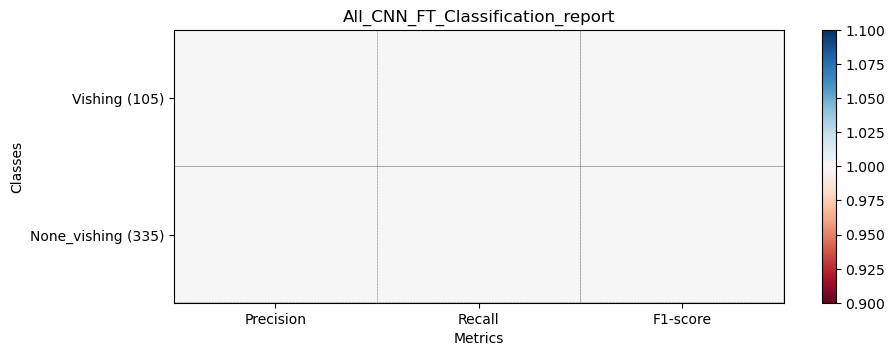

In [140]:
#plot the confusion matrix
plot_name = augmented_dataset + '_CNN_FT_Classification_report'
plot_classification_report(report_cnn_ft, plot_name)

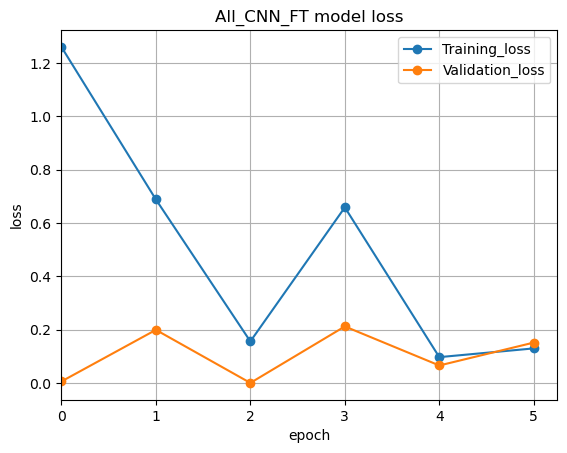

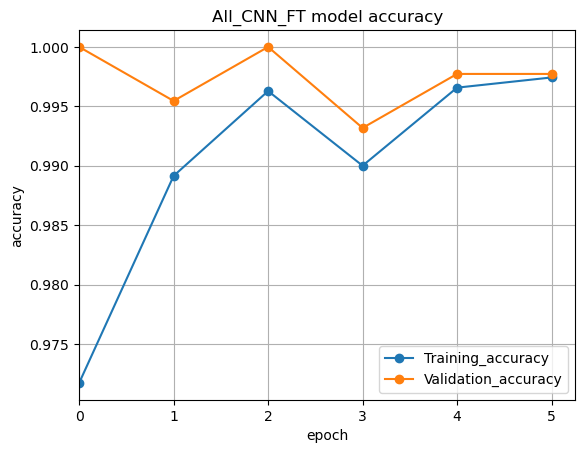

In [141]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_CNN_FT'
plot_loss_accuracy(history_cnn_ft, plot_name)

### 1D CNN layer with multiple kernel sizes

In [142]:
# Function to build, train and evaluate the 1D CNN layer with multiple kernel sizes model
def build_train_cnn_multiple_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))

    model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(num_filters, kernel_size+1, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(num_filters, kernel_size+2, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    # model.add(GlobalMaxPooling1D()) #takes the maximum value over the time dimension from each feature map generated by the convolutional layers, Dimensionality Reduction, Reduces Overfitting
    model.add(Dense(dense_units, activation='relu'))
    model.add(Flatten()) # no need if used Global poooling
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )

    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer=Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # print the model summary
    print(model.summary())
    print('#' * 150)

    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy',  # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max'  # max for val_accuracy, min for val_lossmode='mn'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=3,  # Number of epochs with no improvement after which training will be stopped.
        mode='min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time

    # print the training time
    print('Training time: {}'.format(training_time))

    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))

    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))

    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)

    # print the confusion matrix
    # print(confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
        
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    

    # save the model
    # model.save('models/{}.h5'.format(model_name))

    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  

    # print the results
    # df_results

    return model, history, report

In [143]:
# build, train and evaluate the CNN with mulitple kernel sizes model
model_name = augmented_dataset + '_CNN_multiple'
model_cnn_multiple, history_cnn_multiple, report_cnn_multiple = build_train_cnn_multiple_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_22 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 conv1d_10 (Conv1D)          (None, 4715, 50)          45050     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 2357, 50)          0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 2357, 50)          10050     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 1178, 50)        

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 6s 45ms/step - loss: 23.9419 - accuracy: 0.5318 - val_loss: 0.7548 - val_accuracy: 0.2386
Epoch 2/10
109/110 [============================>.] - ETA: 0s - loss: 0.6877 - accuracy: 0.5536
Epoch 2: val_accuracy did not improve from 0.23864
110/110 [==============================] - 3s 26ms/step - loss: 0.6876 - accuracy: 0.5538 - val_loss: 0.7670 - val_accuracy: 0.2386
Epoch 3/10
109/110 [============================>.] - ETA: 0s - loss: 0.6878 - accuracy: 0.5533
Epoch 3: val_accuracy did not improve from 0.23864
110/110 [==============================] - 3s 26ms/step - loss: 0.6877 - accuracy: 0.5538 - val_loss: 0.7402 - val_accuracy: 0.2386
Epoch 4/10
109/110 [============================>.] - ETA: 0s - loss: 0.6879 - accuracy: 0.5536
Epoch 4: val_accuracy did not improve from 0.23864
110/110 [==============================] - 3s 26ms/step - loss: 0.6879 - accuracy: 0.5538 - val_loss: 0.7804 - val_accuracy: 0.2386
Epoch 5/10
109/110 [==========

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [144]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.000000,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.000000,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.000000,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.000000,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.000000,0.761364,167.956002
All_BiLSTM_FT,0.966825,0.962264,0.971429,0.984091,511.583563
All_stackedBiLSTM,0.385321,0.238636,1.000000,0.238636,396.791831
All_stackedBiLSTM_FT,0.949772,0.912281,0.990476,0.975000,804.711993
All_CNN,1.000000,1.000000,1.000000,1.000000,28.366252
All_CNN_FT,1.000000,1.000000,1.000000,1.000000,17.198445


[0.0, 0.0, 0.0]
[0.2386, 1.0, 0.3853]
plotMat: [[0.0, 0.0, 0.0], [0.2386, 1.0, 0.3853]]
support: [335, 105]


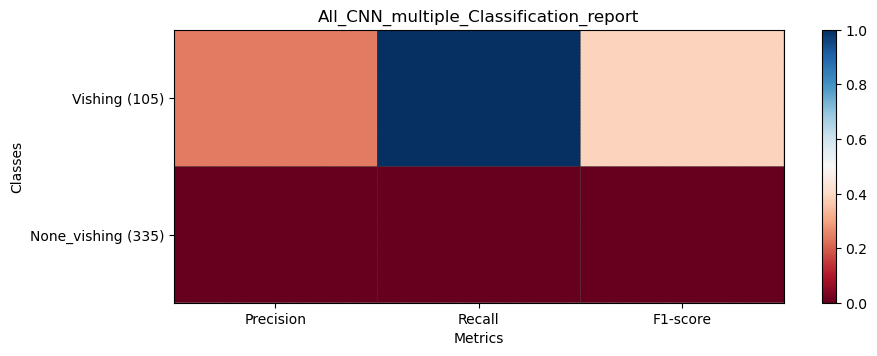

In [145]:
#plot the confusion matrix
plot_name = augmented_dataset + '_CNN_multiple_Classification_report'
plot_classification_report(report_cnn_multiple, plot_name)

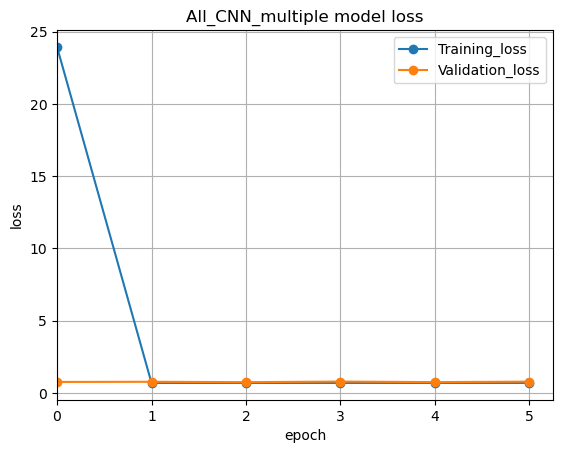

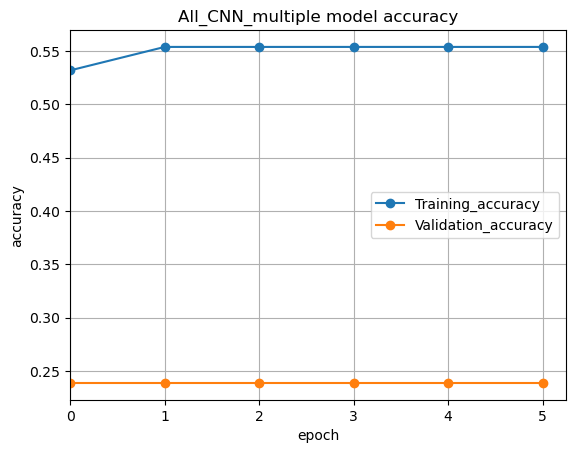

In [146]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_CNN_multiple'
plot_loss_accuracy(history_cnn_multiple, plot_name)

#### 1D CNN layer with multiple kernel sizes with FastText embedding layer

In [147]:
# build, train and evaluate the CNN with multiple kernel sizes model with FastText embedding layer
model_name = augmented_dataset + '_CNN_multiple_FT'
model_cnn_multiple_ft, history_cnn_multiple_ft, report_cnn_multiple_ft = build_train_cnn_multiple_model(model_name, X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 4715, 300)         10490400  
                                                                 
 spatial_dropout1d_23 (Spat  (None, 4715, 300)         0         
 ialDropout1D)                                                   
                                                                 
 conv1d_13 (Conv1D)          (None, 4715, 50)          45050     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 2357, 50)          0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 2357, 50)          10050     
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 1178, 50)        

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 5s 34ms/step - loss: 5.0730 - accuracy: 0.8072 - val_loss: 0.1218 - val_accuracy: 0.9477
Epoch 2/10
109/110 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.9736
Epoch 2: val_accuracy improved from 0.94773 to 0.98182, saving model to models/All_CNN_multiple_FT_20240227_041316.h5
110/110 [==============================] - 3s 30ms/step - loss: 0.0994 - accuracy: 0.9734 - val_loss: 0.0448 - val_accuracy: 0.9818
Epoch 3/10
109/110 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9908
Epoch 3: val_accuracy improved from 0.98182 to 0.99773, saving model to models/All_CNN_multiple_FT_20240227_041316.h5
110/110 [==============================] - 3s 29ms/step - loss: 0.0366 - accuracy: 0.9909 - val_loss: 0.0144 - val_accuracy: 0.9977
Epoch 4/10
109/110 [============================>.] - ETA: 0s - loss: 0.0243 - accuracy: 0.9934
Epoch 4: val_accuracy did not improve from 0.99773
110/110 [====================

In [148]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
All_LSTM,0.385321,0.238636,1.000000,0.238636,221.337700
All_LSTM_FT,0.000000,0.000000,0.000000,0.761364,79.767133
All_stackedLSTM,0.385321,0.238636,1.000000,0.238636,351.369261
All_stackedLSTM_FT,0.995261,0.990566,1.000000,0.997727,502.263439
All_BiLSTM,0.000000,0.000000,0.000000,0.761364,167.956002
All_BiLSTM_FT,0.966825,0.962264,0.971429,0.984091,511.583563
All_stackedBiLSTM,0.385321,0.238636,1.000000,0.238636,396.791831
All_stackedBiLSTM_FT,0.949772,0.912281,0.990476,0.975000,804.711993
All_CNN,1.000000,1.000000,1.000000,1.000000,28.366252
All_CNN_FT,1.000000,1.000000,1.000000,1.000000,17.198445


[0.997, 1.0, 0.9985]
[1.0, 0.9905, 0.9952]
plotMat: [[0.997, 1.0, 0.9985], [1.0, 0.9905, 0.9952]]
support: [335, 105]


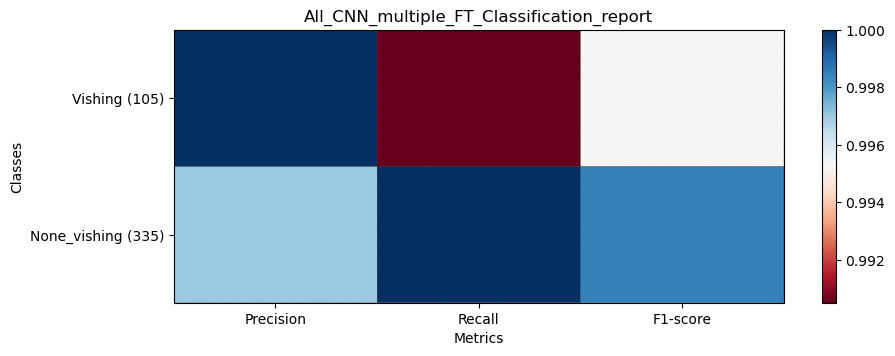

In [149]:
#plot the confusion matrix
plot_name = augmented_dataset + '_CNN_multiple_FT_Classification_report'
plot_classification_report(report_cnn_multiple_ft, plot_name)

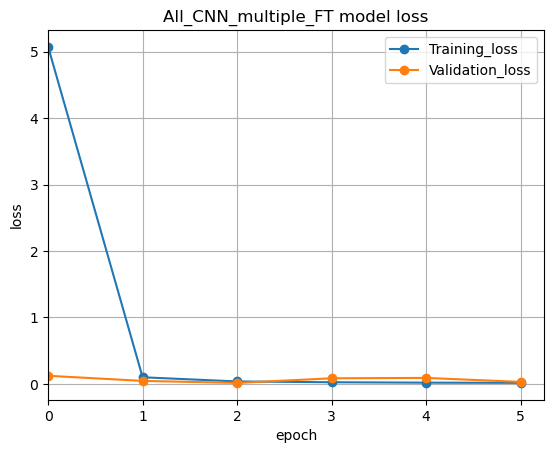

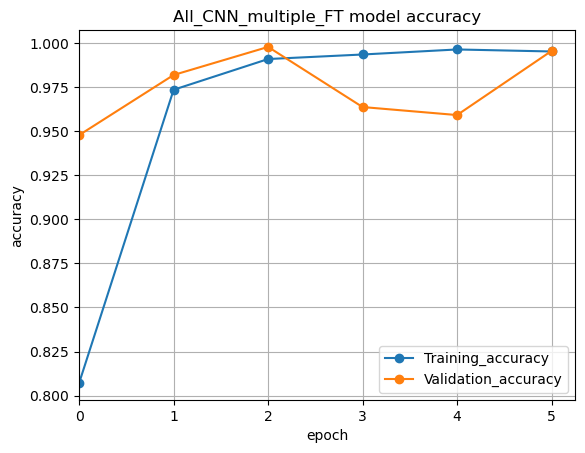

In [150]:
#plot the training and validation loss and accuracy
plot_name = augmented_dataset + '_CNN_multiple_FT'
plot_loss_accuracy(history_cnn_multiple_ft, plot_name)

## save the results in csv

In [151]:
# save the training results
df_results.to_csv("reports/" + augmented_dataset+ " _Models_performance_summary_" + datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".csv")

## Plot all the models performance


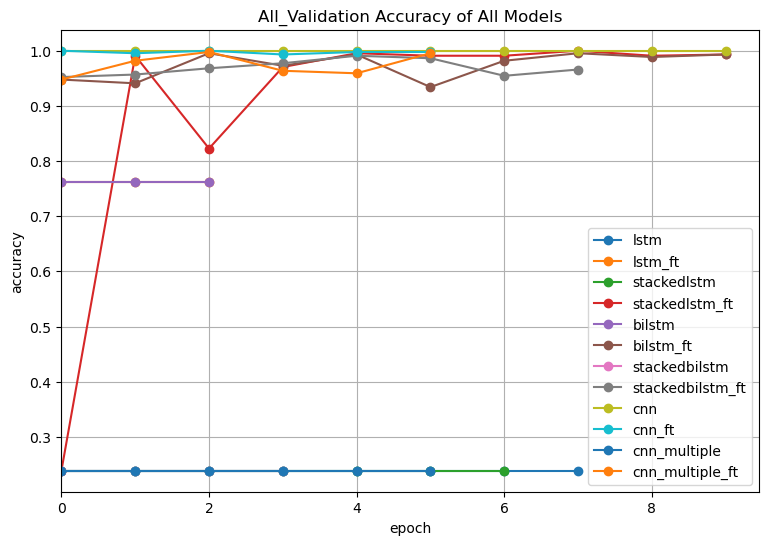

In [152]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_lstm.epoch, history_lstm.history['val_accuracy'], '-o', label='lstm')
plt.plot(history_lstm_ft.epoch, history_lstm_ft.history['val_accuracy'], '-o', label='lstm_ft')
plt.plot(history_stackedlstm.epoch, history_stackedlstm.history['val_accuracy'], '-o', label='stackedlstm')
plt.plot(history_stackedlstm_ft.epoch, history_stackedlstm_ft.history['val_accuracy'], '-o', label='stackedlstm_ft')
plt.plot(history_bilstm.epoch, history_bilstm.history['val_accuracy'], '-o', label='bilstm')
plt.plot(history_bilstm_ft.epoch, history_bilstm_ft.history['val_accuracy'], '-o', label='bilstm_ft')
plt.plot(history_stackedbilstm.epoch, history_stackedbilstm.history['val_accuracy'], '-o', label='stackedbilstm')
plt.plot(history_stackedbilstm_ft.epoch, history_stackedbilstm_ft.history['val_accuracy'], '-o', label='stackedbilstm_ft')
plt.plot(history_cnn.epoch, history_cnn.history['val_accuracy'], '-o', label='cnn')
plt.plot(history_cnn_ft.epoch,history_cnn_ft.history['val_accuracy'], '-o', label='cnn_ft')
plt.plot(history_cnn_multiple.epoch, history_cnn_multiple.history['val_accuracy'], '-o', label='cnn_multiple')
plt.plot(history_cnn_multiple_ft.epoch, history_cnn_multiple_ft.history['val_accuracy'], '-o', label='cnn_multiple_ft')
plt.title(augmented_dataset+'_Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('reports/'+augmented_dataset+'_All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('reports/'+augmented_dataset+'_All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

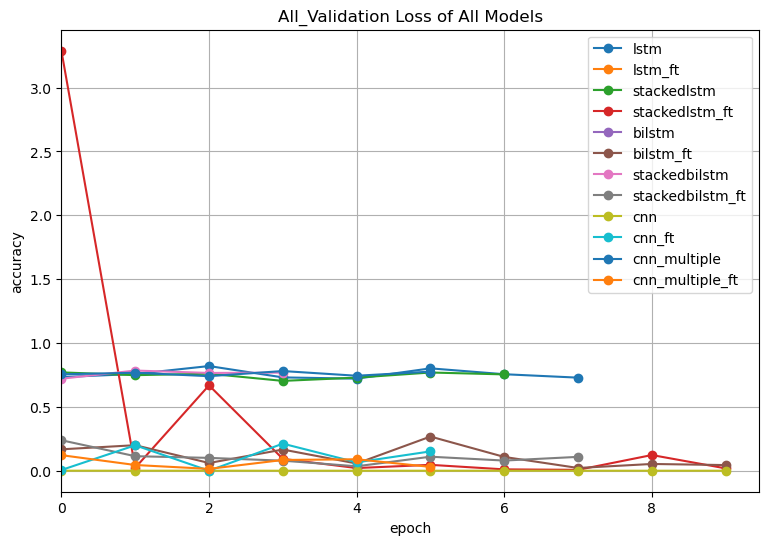

In [153]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_lstm.epoch, history_lstm.history['val_loss'], '-o', label='lstm')
plt.plot(history_lstm_ft.epoch, history_lstm_ft.history['val_loss'], '-o', label='lstm_ft')
plt.plot(history_stackedlstm.epoch, history_stackedlstm.history['val_loss'], '-o', label='stackedlstm')
plt.plot(history_stackedlstm_ft.epoch, history_stackedlstm_ft.history['val_loss'], '-o', label='stackedlstm_ft')
plt.plot(history_bilstm.epoch, history_bilstm.history['val_loss'], '-o', label='bilstm')
plt.plot(history_bilstm_ft.epoch, history_bilstm_ft.history['val_loss'], '-o', label='bilstm_ft')
plt.plot(history_stackedbilstm.epoch, history_stackedbilstm.history['val_loss'], '-o', label='stackedbilstm')
plt.plot(history_stackedbilstm_ft.epoch, history_stackedbilstm_ft.history['val_loss'], '-o', label='stackedbilstm_ft')
plt.plot(history_cnn.epoch, history_cnn.history['val_loss'], '-o', label='cnn')
plt.plot(history_cnn_ft.epoch, history_cnn_ft.history['val_loss'], '-o', label='cnn_ft')
plt.plot(history_cnn_multiple.epoch, history_cnn_multiple.history['val_loss'], '-o', label='cnn_multiple')
plt.plot(history_cnn_multiple_ft.epoch, history_cnn_multiple_ft.history['val_loss'], '-o', label='cnn_multiple_ft')
plt.title(augmented_dataset+'_Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('reports/'+augmented_dataset+'_All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('reports/'+augmented_dataset+'_All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()